# Proposal 1

$$
\mathcal{L} = \mathcal{L}_c + \lambda_1 || \bm{u} \odot \bm{(\theta - \theta^*_A)} ||_1 + \lambda_2 || (\bm{1 - u}) \odot \bm{(\theta - \theta^*_A)}||_2^2
$$

In [74]:
%load_ext autoreload
%autoreload 2

# Libraries

In [75]:
import pickle
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [76]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

## Custom Libraries

In [77]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import CEWCV1
from base_code.plugins import WeightStoragePlugin

# Device

In [78]:
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [79]:
scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [80]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [81]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=device),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning:

Your system has no GPU!

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning:

Your system has no GPU!



## Plugin defitinitions

In [82]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [69]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(device)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss().to(device)
strategy = CEWCV1(
    model,
    optimizer,
    criterion,
    ewc_lambda_l1=1.0,
    ewc_lambda_l2=1.0,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=device,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 106.64it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 130.1000
	Loss_MB/train_phase/train_stream/Task000 = 4.2970
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 4.3980
100%|██████████| 469/469 [00:04<00:00, 111.20it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 121.9000
	Loss_MB/train_phase/train_stream/Task000 = 4.2852
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.2180
100%|██████████| 469/469 [00:04<00:00, 107.38it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 100.5000
	Loss_MB/train_phase/train_stream/Task000 = 4.9131
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.3678
100%|██████████| 469/469 [00:04<00:00, 108.01it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:33<05:01, 33.53s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3892
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16d7bcf70>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 20%|██        | 2/10 [01:06<04:25, 33.20s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5360
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15e6bb6d0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 30%|███       | 3/10 [01:38<03:48, 32.71s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5674
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15e87bc40>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 40%|████      | 4/10 [02:12<03:18, 33.04s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0513
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15ed9ed90>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 50%|█████     | 5/10 [02:44<02:44, 32.86s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.9142
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15f910dc0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 60%|██████    | 6/10 [03:18<02:13, 33.29s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3941
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15ed9e790>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.5271, 0.7307, 0.7606, 0.7802, 0.8165, 0.8315, 0.1449, 0.2091, 0.1842,
         0.1017],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
     

 70%|███████   | 7/10 [03:51<01:39, 33.02s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.9675
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16091e0a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.5271, 0.7307, 0.7606, 0.7802, 0.8165, 0.8315, 0.1449, 0.2091, 0.1842,
         0.1017],
        [0.4258, 0.6986, 0.7016, 0.7642, 0.7799, 0.8144, 0.8294, 0.1576, 0.1721,
         0.0757],
     

 80%|████████  | 8/10 [04:23<01:05, 32.81s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5780
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x160c86700>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.5271, 0.7307, 0.7606, 0.7802, 0.8165, 0.8315, 0.1449, 0.2091, 0.1842,
         0.1017],
        [0.4258, 0.6986, 0.7016, 0.7642, 0.7799, 0.8144, 0.8294, 0.1576, 0.1721,
         0.0757],
     

 90%|█████████ | 9/10 [04:55<00:32, 32.64s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.6219
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17f63ee80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.5271, 0.7307, 0.7606, 0.7802, 0.8165, 0.8315, 0.1449, 0.2091, 0.1842,
         0.1017],
        [0.4258, 0.6986, 0.7016, 0.7642, 0.7799, 0.8144, 0.8294, 0.1576, 0.1721,
         0.0757],
     

100%|██████████| 10/10 [05:28<00:00, 32.85s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.1010
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17f9af4f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 700.5615
	EvalStream/Acc_Matrix = 
tensor([[0.7595, 0.2119, 0.1720, 0.1914, 0.1503, 0.1565, 0.2179, 0.1394, 0.1738,
         0.1784],
        [0.7137, 0.7803, 0.1889, 0.1957, 0.1774, 0.1469, 0.1972, 0.1195, 0.1704,
         0.2127],
        [0.6260, 0.7549, 0.7850, 0.1446, 0.1196, 0.1761, 0.1991, 0.1481, 0.1927,
         0.1211],
        [0.6074, 0.7509, 0.7774, 0.8036, 0.1192, 0.1215, 0.1946, 0.1993, 0.1703,
         0.1058],
        [0.5552, 0.7578, 0.7792, 0.7776, 0.8164, 0.1277, 0.1371, 0.1757, 0.2053,
         0.1314],
        [0.5271, 0.7307, 0.7606, 0.7802, 0.8165, 0.8315, 0.1449, 0.2091, 0.1842,
         0.1017],
        [0.4258, 0.6986, 0.7016, 0.7642, 0.7799, 0.8144, 0.8294, 0.1576, 0.1721,
         0.0757],
     

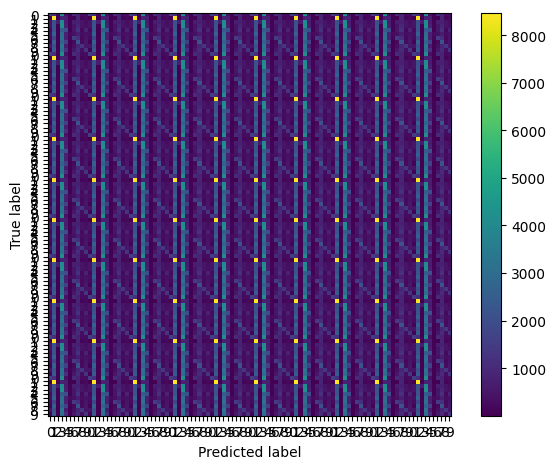

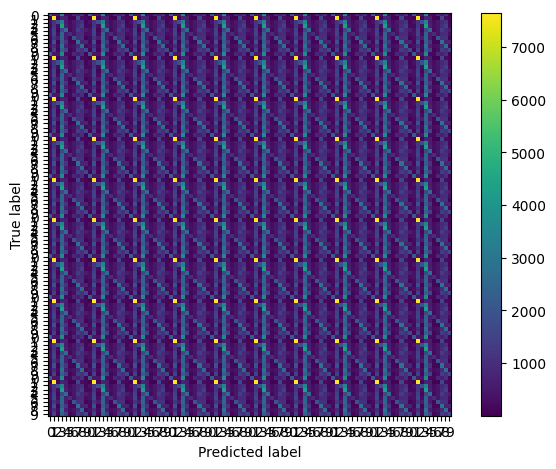

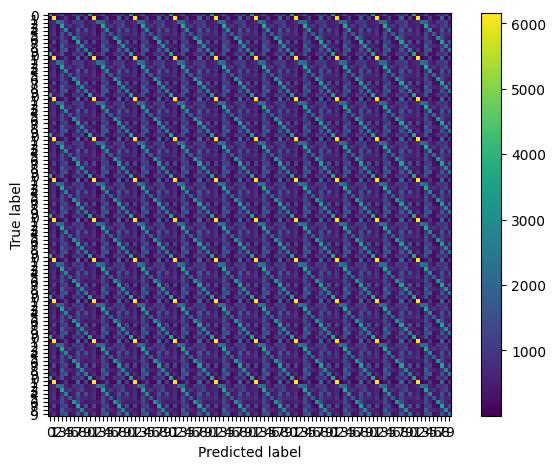

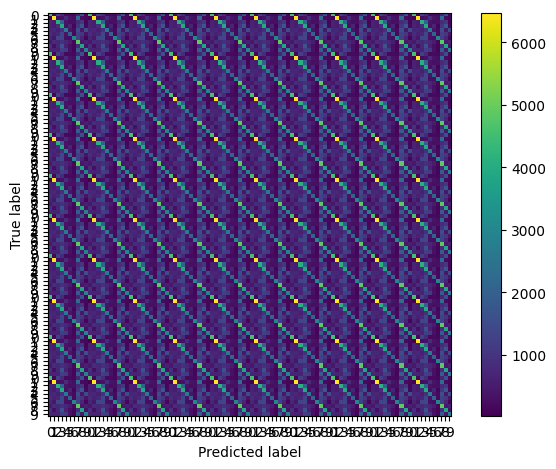

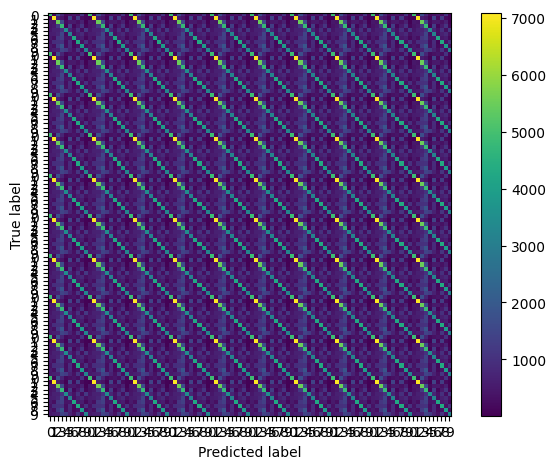

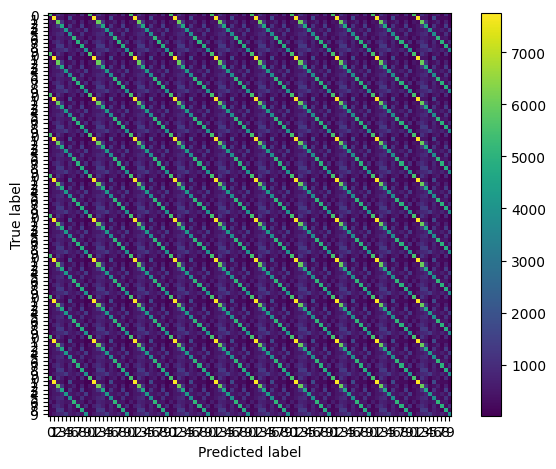

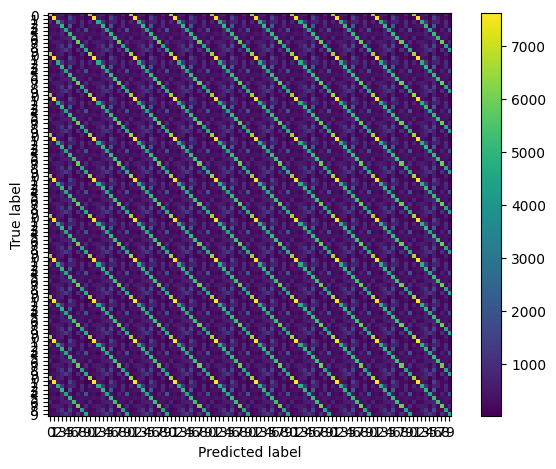

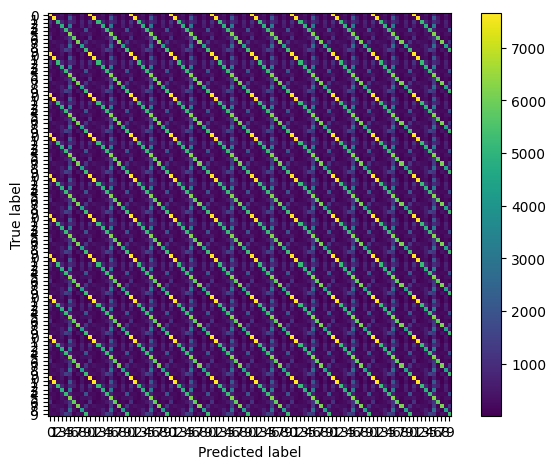

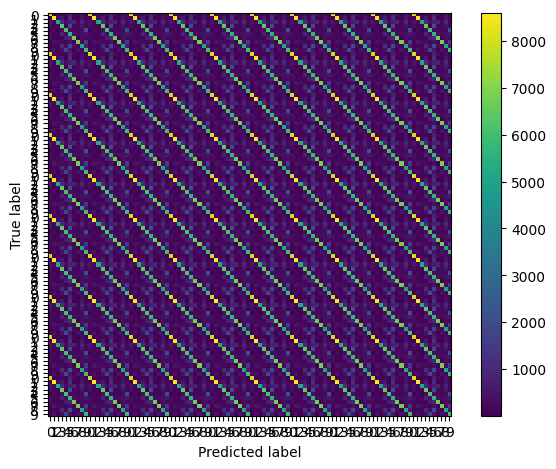

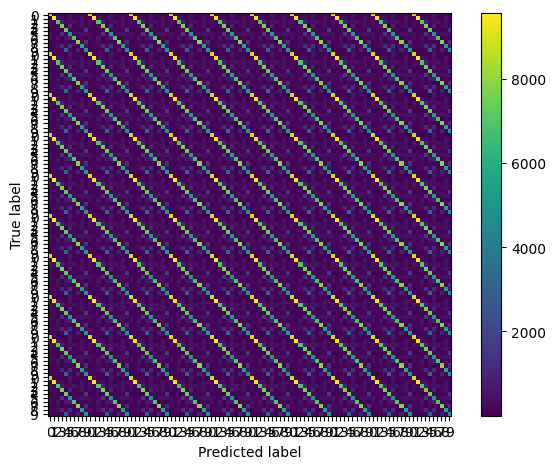

In [70]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

# Get metrics

In [73]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [74]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [75]:
all_loss_components = strategy.get_store_loss()

In [76]:
weights = model_plugins[0].weights

# Store metrics

In [ ]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / "cewc_v1.pkl", "wb"))

# Load

In [8]:
metrics = pickle.load(open(SAVED_METRICS_PATH / "cewc_v1.pkl", "rb"))

# Plot metrics

## Accuracy

In [18]:
fig = px.line(
    pd.DataFrame(metrics["accuracies"]),
    title="Accuracy vs Task",
    labels=dict(index="Task", value="Accuracy"),
    width=800,
    height=600,
    range_y=[0, 1],
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Forgetting

In [73]:
forgetting_processed = dict()
for i, (key, value) in enumerate(metrics["forgettings"].items()):
    forgetting_processed[key] = [float("nan")] * i + value

fig = px.line(
    pd.DataFrame(forgetting_processed),
    title="Forgetting vs Task",
    labels=dict(index="Task", value="Forgetting"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Losses

In [27]:
fig = px.line(
    pd.DataFrame(metrics["losses"]),
    title="Losses vs Task",
    labels=dict(index="Task", value="Loss"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## CPU Usage

In [83]:
fig = px.line(
    metrics["train_cpu_usage"],
    title="CPU Usage vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Time per epoch

In [36]:
fig = px.line(
    metrics["train_time_epoch"],
    title="Time per Epoch vs Epoch",
    labels=dict(index="Epoch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Running time

In [84]:
fig = px.line(
    metrics["train_running_time"],
    title="Running Time vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Training loss

In [85]:
fig = px.line(
    metrics["train_loss_epoch"],
    title="Loss vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## All components losses

In [86]:
fig = px.line(
    metrics["all_loss_components"],
    title="Loss Components vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Weights used

In [55]:
used_weights = list(map(lambda x: sum((abs(x) > 1e-5)).item(), metrics["weights"]))

In [87]:
fig = px.line(
    used_weights,
    title="Used Weights vs Task",
    labels=dict(index="Task", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()